# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [2]:
#Importar dependecias necesarias
import tensorflow as tf
tf.enable_eager_execution()
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
import numpy as np
import math


## Planteamiento de la solucion
El primer paso para solucionar el problema es leer los datos

In [3]:
def clean_data(data):
    data = pd.read_excel(data_path + filenames[16], header=2, parse_col="A:Z")
    return data


In [4]:
"""
    Data is located and filtered for temporary files 
    It is asumed that the directory will not have any other
    files exept for the excel files where the data is located
"""
data_path = "datos/precios/"
filenames = os.listdir(data_path)
filenames = [e for e in filenames if e[0] != '~']


In [5]:
file = pd.read_excel(data_path + filenames[5], header=2, usecols="A:Y")
file.head()

,Fecha,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,2000-01-01,46.284788,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,...,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788
1,2000-01-02,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,...,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,50.284788,32.284788,32.284788,32.284788
2,2000-01-03,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,32.284788,...,32.284788,32.284788,32.284788,32.284788,50.284788,50.284788,39.284788,50.284788,32.284788,32.284788
3,2000-01-04,32.284788,32.284788,32.284788,32.284788,32.284788,46.284788,32.284788,32.284788,50.284788,...,41.284788,41.284788,47.984788,32.284788,50.284788,50.284788,50.284788,50.284788,39.284788,32.284788
4,2000-01-05,32.284788,32.284788,32.284788,32.284788,32.284788,46.284788,41.284788,39.284788,49.284788,...,47.984788,41.284788,47.984788,32.284788,48.484788,50.284788,32.284788,49.284788,51.284788,46.284788


In [6]:
"""
    In this step data is loaded, cleaned and appended, nans still remain,
    the data tail is shown to make certain the data was loaded correctly
"""

data = pd.read_excel(data_path + filenames[0], header=3, usecols="A:Y")

iterfiles = iter(filenames) 
next(iterfiles)

i = 1
for f in iterfiles:
    
    #print("iter " + str(i))

    if i < 5:
        file = pd.read_excel(data_path + f, header=3, usecols="A:Y")
        #print("Here")
    else:
        file = pd.read_excel(data_path + f, header=2, usecols="A:Y")
    data = data.append(file, sort=False , ignore_index=True)
    i += 1
    #print(file.columns)
data = data.drop("Fecha", axis=1)
data.tail()


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
8404,64.229226,64.229226,64.129226,64.129226,64.129226,64.129226,64.129226,64.229226,64.229226,69.229226,...,71.229226,71.229226,69.229226,81.229226,86.229226,86.229226,86.229226,81.229226,71.229226,64.229226
8405,63.332816,63.332816,63.332816,63.332816,63.332816,64.332816,67.832816,79.831816,80.832816,80.832816,...,83.832816,83.832816,80.832816,80.832816,83.832816,83.832816,83.832816,80.832816,80.832816,67.832816
8406,63.710848,64.210848,61.710848,61.710848,63.710848,64.210848,64.210848,67.710848,67.710848,67.710848,...,79.710848,79.710848,79.710848,67.710848,79.710848,79.710848,79.710848,67.710848,67.710848,63.710848
8407,61.543453,61.543453,61.543453,61.543453,61.543453,65.543453,61.543453,64.043453,65.543453,65.543453,...,65.543453,65.543453,65.543453,65.543453,65.543453,72.543453,65.543453,65.543453,65.543453,64.043453
8408,73.742918,73.742918,70.242918,70.242918,70.242918,70.242918,73.742918,73.742918,75.242918,75.242918,...,73.742918,73.742918,75.242918,73.742918,75.242918,75.242918,75.242918,75.242918,75.242918,75.242918


In [7]:
nans = sum(pd.isnull(data).sum().values)
nans_per = 1 - (len(data.index) - nans) / len(data.index)

"""
    3% of the data are NaNs, since the porcentage is not so big
    3% < 5%, which is a common confidence value, it is mostly safe
    to delete the rows where NaNs are present without inquiring in bias
    print(str(nans_per * 100) + "%")
"""

data.dropna(how="any", inplace=True)
data.reset_index(drop=True)
print("Number of rows left: " + str(len(data.index)))
data.tail()

Number of rows left: 8381


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
8404,64.229226,64.229226,64.129226,64.129226,64.129226,64.129226,64.129226,64.229226,64.229226,69.229226,...,71.229226,71.229226,69.229226,81.229226,86.229226,86.229226,86.229226,81.229226,71.229226,64.229226
8405,63.332816,63.332816,63.332816,63.332816,63.332816,64.332816,67.832816,79.831816,80.832816,80.832816,...,83.832816,83.832816,80.832816,80.832816,83.832816,83.832816,83.832816,80.832816,80.832816,67.832816
8406,63.710848,64.210848,61.710848,61.710848,63.710848,64.210848,64.210848,67.710848,67.710848,67.710848,...,79.710848,79.710848,79.710848,67.710848,79.710848,79.710848,79.710848,67.710848,67.710848,63.710848
8407,61.543453,61.543453,61.543453,61.543453,61.543453,65.543453,61.543453,64.043453,65.543453,65.543453,...,65.543453,65.543453,65.543453,65.543453,65.543453,72.543453,65.543453,65.543453,65.543453,64.043453
8408,73.742918,73.742918,70.242918,70.242918,70.242918,70.242918,73.742918,73.742918,75.242918,75.242918,...,73.742918,73.742918,75.242918,73.742918,75.242918,75.242918,75.242918,75.242918,75.242918,75.242918


In [8]:
"""
    With the nans out of the way, the next step is calculate the means per row 
    to form the series of daily mean prices
"""

mean_prices = data.sum(axis=1) / (len(data.columns))


In [9]:
import scipy
import scipy.stats

plt.figure(figsize=(14,3))
xt, lamda, interval = scipy.stats.boxcox(mean_prices, alpha=0.05)
print("lambda = {:g}".format(lamda))

print("Confidence interval for the lambda = (" + str(round(interval[0], 5)) + ", " + str(round(interval[1], 5)) + ")")



lambda = 0.202402
Confidence interval for the lambda = (0.18908, 0.21578)


<Figure size 1008x216 with 0 Axes>

In [10]:
plt.figure(figsize=(14,3))
#plt.plot(mean_prices)
#plt.plot(np.sqrt(mean_prices))
#plt.plot(np.power(mean_prices, 1/3))

#Scaling data
def scale_data(data, c = 0, d = 1):
    
    out = data.tolist()
    b = max(out)
    a = min(out)
    out = [c + ((d-(c))/(b-a))*(e-a) for e in out]

    return out, a, b

def de_scale_data(s_data, a, b, c = 0, d = 1):
    p = (d-c)/(b-a)
    out = [(y + (p*a) -c)/p for y in s_data]
    #out = [a + ((b-a)/(d-c))*(e-c) for e in s_data]
    return out


d, a, b = scale_data(xt)
ds = de_scale_data(d, a, b)

#plt.plot(xt)
#plt.plot(ds)
#plt.plot(d)
#this is a test of the de_scale function


<Figure size 1008x216 with 0 Axes>

In [11]:
class Model(object):
    
    def __init__(self, L):
        self.w = tf.contrib.eager.Variable([0.0] * (L+1))
        self.errs = []
        self.last_delta = 0;
    def __call__(self, x):
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred
                             
    def fit(self, mu, x, y_desired):
        y_pred = self(x)
        e = y_desired - y_pred
        self.errs.append(e)
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x)) 
        
    def fit_momentum(self, mu, mu2, x, y_desired):
        y_pred = self(x)
        e = y_desired - y_pred
        self.errs.append(e)
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        delta = 2 * e
        self.w.assign_add(tf.scalar_mul(mu * delta + mu2 * self.last_delta, x))   

In [12]:
def fit_model(d, L, u, u2 = 0.05, fit_type = 0):
    model = Model(L)
    y_pred = np.empty(len(d))
    y_pred[:] = 0
    for t in range(L, len(d)):
        x = d[t-L:t]                        
        y_pred[t] = model(x)
        if fit_type == 0:
            model.fit(mu=u, x=x, y_desired=d[t])
        else:
            model.fit_momentum(mu=u, mu2=u2, x=x, y_desired=d[t])
    return model, y_pred,

In [15]:
from tqdm import tqdm_notebook as tqdm

tests = {"fit_type": [], "L": [], "mu": [], "mu2": [], "MSE": []}

n_of_fits = 2
max_l = 10
max_mu = 0.5
mu_step = 0.1
max_mu2 = 0.5
mu2_step = 0.1

tsum = 0
for fit_type in range(2):
    for L in (1, max_l):
        for mu in np.arange(0.01, max_mu, step=mu_step):
            for mu2 in np.arange(0.01, max_mu2, step=mu2_step):
                tsum += 1
                
 
     

total = n_of_fits * max_l * (max_mu/mu_step) * (max_mu2/mu2_step)
pbar = tqdm(total = tsum)
for fit_type in range(2):
    for L in (1, max_l):
        for mu in np.arange(0.01, max_mu, step=mu_step):
            for mu2 in np.arange(0.01, max_mu2, step=mu2_step):
                if fit_type == 0:
                    model, y_pred = fit_model(d, L, mu, mu2, 0)
                else:
                    model, y_pred = fit_model(d, L, mu, mu2, 1)
                
                MSE = sum(model.errs)**2 / len(model.errs)
                tests["fit_type"].append(fit_type)
                tests["L"].append(L)
                tests["mu"].append(mu)
                tests["mu2"].append(mu2)
                tests["MSE"].append(MSE)
                pbar.update(1)
pbar.close()               
runs = pd.DataFrame(tests)

In [16]:
##Here the best
mss = [e.numpy() for e in runs["MSE"][:]]
best_params_ix = mss.index(min(mss))
best_params = runs.iloc[best_params_ix]
print(best_params)
print(len(mss))

fit_type                                                   0
L                                                          1
mu                                                      0.41
mu2                                                     0.01
MSE         tf.Tensor(6.882145e-05, shape=(), dtype=float32)
Name: 20, dtype: object
100


In [17]:
runs.tail()

,fit_type,L,mu,mu2,MSE
95,1,10,0.41,0.01,"tf.Tensor(nan, shape=(), dtype=float32)"
96,1,10,0.41,0.11,"tf.Tensor(nan, shape=(), dtype=float32)"
97,1,10,0.41,0.21,"tf.Tensor(nan, shape=(), dtype=float32)"
98,1,10,0.41,0.31,"tf.Tensor(nan, shape=(), dtype=float32)"
99,1,10,0.41,0.41,"tf.Tensor(nan, shape=(), dtype=float32)"


Mean error of the scaled data is tf.Tensor(6.882145e-05, shape=(), dtype=float32)


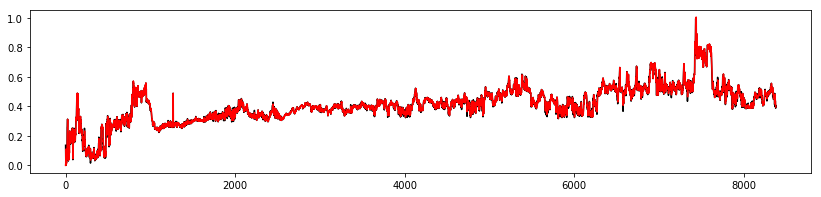

In [18]:
fit_type = 1#best_params["fit_type"]
L = best_params["L"]
mu = best_params["mu"]
mu2 = best_params["mu2"]


model, y_pred = fit_model(d, L, mu, mu2, fit_type)
MSE = sum(model.errs)**2 / len(model.errs)
print("Mean error of the scaled data is " + str(MSE))
plt.figure(figsize=(14,3))
plt.plot(d, color='black');
plt.plot(y_pred, color = 'red');


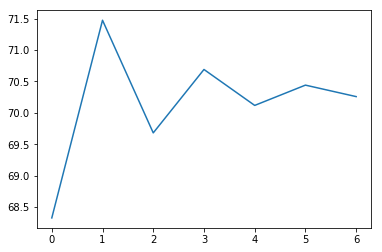

In [19]:
nd = d[-L:] 

n_of_pred = 7
for i in range(n_of_pred):
    #print(-(L))
    #print(nd[-L:])
    nd.append(model(nd[-L:]).numpy())
    #print(model(nd[-1 * (L - 1):]))
seven_pred = de_scale_data(nd[-1*n_of_pred:], a, b)
seven_pred = scipy.special.inv_boxcox(seven_pred, lamda)
plt.plot(seven_pred);
